### Setting

In [1]:
# Device

import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is available and will be used.")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

GPU is available and will be used.


In [2]:
#Imports

import os
import json
import random
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer, BertConfig, BertForMaskedLM, DataCollatorForLanguageModeling,
    TapasTokenizer, TapasForMaskedLM,
    AdamW, get_scheduler
)
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from model_complete import JSONBERT_COMPLETE
from dataset import JSONDataset, create_data

import sys
sys.path.append('/root/woojun/')

from utils import (
    _serialize_vanilla,
    _serialize,
    _find_key_positions,
    tokenize_table,
    get_table_embedding
)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available and will be used.


In [3]:
# Tokenizer & config

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained('bert-base-uncased')

In [4]:
# Models

# BERT
bert_base = BertForMaskedLM.from_pretrained('bert-base-uncased')
bert_base = bert_base.to(device)

# TaPas
tapas_name = "google/tapas-base-masklm"
tapas_tokenizer = TapasTokenizer.from_pretrained(tapas_name)
tapas = TapasForMaskedLM.from_pretrained(tapas_name)
tapas.to(device)

# Ours
ours_path_movie = './models/movie_complete/epoch-9'
ours_movie = JSONBERT_COMPLETE(config, tokenizer, ours_path_movie)
ours_movie = ours_movie.to(device)

ours_path_product = './models/product_complete/epoch-9'
ours_product = JSONBERT_COMPLETE(config, tokenizer, ours_path_product)
ours_product = ours_product.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Key embeddings are trainable!
Pre-trained JSONBERT loaded from ./models/movie_complete/epoch-9
Key embeddings are trainable!
Pre-trained JSONBERT loaded from ./models/product_complete/epoch-9


In [5]:
# BERT
bert_movie = BertForMaskedLM.from_pretrained('./models/movie_bert/epoch-9', local_files_only=True)
bert_movie = bert_movie.to(device)

bert_product = BertForMaskedLM.from_pretrained('./models/product_bert/epoch-9', local_files_only=True)
bert_product = bert_product.to(device)

### Preprocessing

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

def get_word_embedding(word):
    inputs = tokenizer.tokenize(word)
    inputs = tokenizer.encode_plus(word, return_tensors='pt', add_special_tokens=True).to(device)
    with torch.no_grad():
        outputs = bert_base(**inputs, output_hidden_states=True)

    last_hidden_state = outputs.hidden_states[-1]
    embedding = last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

    return embedding

def get_sorted_columns_by_similarity(emb, column_embs, columns):
    # Calculate cosine similarity between emb and each column embedding
    similarities = [cosine_similarity(emb.reshape(1, -1), emb.reshape(1, -1))[0][0] for emb in column_embs]
    
    # Pair column names with their corresponding similarity scores
    columns_with_similarity = list(zip(columns, similarities))

    # Sort columns by similarity in descending order
    sorted_columns = sorted(columns_with_similarity, key=lambda x: x[1], reverse=True)

    # Return only the sorted column names
    sorted_column_names = [col for col, sim in sorted_columns]

    return sorted_column_names


#### Inspecting all data in Movie_100 and Product_100

In [ ]:
# # Movie

# pretraining_movie_path = './data/pretraining_data_movie.jsonl'
# movie_path = './data/Movie_top100'
# movie_json = create_data(movie_path, path_is="test", sample_num=20, pretraining_path=pretraining_movie_path)

In [ ]:
# len(movie_json)

In [ ]:
# # Product
# pretraining_product_path = './data/pretraining_data_product.jsonl'
# product_path = './data/Product_top100'
# product_json = create_data(product_path, path_is="test", sample_num=20, pretraining_path=pretraining_product_path)

In [ ]:
# len(product_json)

#### Finding the right table!

In [ ]:
# # Directory containing the JSON files
# directory = './data/Movie_top100'

# # List to store filenames with their respective number of keys
# file_key_counts = []

# # Traverse through the directory and process each JSON file
# for filename in os.listdir(directory):
#     if filename.endswith(".json"):
#         filepath = os.path.join(directory, filename)
#         with open(filepath, "r", encoding="utf-8") as f:
#             rows = [json.loads(line) for line in f]
            
#             # Calculate the number of keys from the first dictionary
#             if rows and isinstance(rows, list) and isinstance(rows[0], dict):
#                 num_keys = len(rows[0].keys())
#                 file_key_counts.append((filename, num_keys))

# # Sort the files by the number of keys in descending order
# file_key_counts.sort(key=lambda x: x[1], reverse=True)

# # Print the results
# for filename, num_keys in file_key_counts:
#     print(f"{filename}: {num_keys}")

In [ ]:
# # Directory containing the JSON files
# directory = './data/Product_top100'

# # List to store filenames with their respective number of keys
# file_key_counts = []

# # Traverse through the directory and process each JSON file
# for filename in os.listdir(directory):
#     if filename.endswith(".json"):
#         filepath = os.path.join(directory, filename)
#         with open(filepath, "r", encoding="utf-8") as f:
#             rows = [json.loads(line) for line in f]
            
#             # Calculate the number of keys from the first dictionary
#             if rows and isinstance(rows, list) and isinstance(rows[0], dict):
#                 num_keys = len(rows[0].keys())
#                 file_key_counts.append((filename, num_keys))

# # Sort the files by the number of keys in descending order
# file_key_counts.sort(key=lambda x: x[1], reverse=True)

# # Print the results
# for filename, num_keys in file_key_counts:
#     print(f"{filename}: {num_keys}")

### Entity Matching

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import entropy

def manual_cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def entity_matching(E1_list, E2_list, model1, tokenizer1, model2, tokenizer2, model3, tokenizer3):
    # Calculate similarity distributions
    E1_embeddings_1 = np.array([get_table_embedding(row, model1, tokenizer1) for row in E1_list])
    E2_embeddings_1 = np.array([get_table_embedding(row, model1, tokenizer1) for row in E2_list])
    sim_E1_E2_1 = np.array([manual_cosine_similarity(e1, e2) for e1 in E1_embeddings_1 for e2 in E2_embeddings_1])

    E1_embeddings_2 = np.array([get_table_embedding(row, model2, tokenizer2) for row in E1_list])
    E2_embeddings_2 = np.array([get_table_embedding(row, model2, tokenizer2) for row in E2_list])
    sim_E1_E2_2 = np.array([manual_cosine_similarity(e1, e2) for e1 in E1_embeddings_2 for e2 in E2_embeddings_2])

    E1_embeddings_3 = np.array([get_table_embedding(row, model3, tokenizer3) for row in E1_list])
    E2_embeddings_3 = np.array([get_table_embedding(row, model3, tokenizer3) for row in E2_list])
    sim_E1_E2_3 = np.array([manual_cosine_similarity(e1, e2) for e1 in E1_embeddings_3 for e2 in E2_embeddings_3])

    # Plot the distributions
    plt.figure(figsize=(10, 6))

    plt.hist(sim_E1_E2_1, bins=50, alpha=0.7, label='Sim(E1, E2)', color='green', density=True)
    plt.hist(sim_E1_E2_2, bins=50, alpha=0.3, label='Sim(E1, E2)', color='blue', density=True)
    plt.hist(sim_E1_E2_3, bins=50, alpha=0.3, label='Sim(E1, E2)', color='cyan', density=True)

    plt.title('Similarity Distributions')
    plt.xlabel('Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [8]:
movie_path = "./data/Movie_top100/Movie_mymovies.it_October2023.json"
product_path = "./data/Product_top100/Product_taobao.com_October2023.json"

movie = create_data(movie_path, 'json')
product = create_data(product_path, 'json')

movie = random.sample(movie, 2000)
product = random.sample(product, 2000)

In [9]:
movie_columns = list(movie[0].keys())

movie_emb = get_word_embedding("movie")
movie_column_embs = [get_word_embedding(col) for col in movie_columns]

sorted_columns = get_sorted_columns_by_similarity(movie_emb, movie_column_embs, movie_columns)

# Print the sorted columns
print("Columns sorted by similarity to 'movie':")
for col in sorted_columns:
    print(col)

Columns sorted by similarity to 'movie':
image
keywords
sameas
name
description
trailer
countryoforigin
page_url
director
aggregaterating
duration
actor
datecreated
award
row_id


In [10]:
product_columns = list(product[0].keys())

product_emb = get_word_embedding("product")
product_column_embs = [get_word_embedding(col) for col in product_columns]

sorted_columns = get_sorted_columns_by_similarity(product_emb, product_column_embs, product_columns)

# Print the sorted columns
print("Columns sorted by similarity to 'product':")
for col in sorted_columns:
    print(col)

Columns sorted by similarity to 'product':
productid
sku
name
description
review
page_url
aggregaterating
offers
brand
mpn
row_id
category


In [11]:
print(f"number of rows in movie: {len(movie)}")
print(f"number of rows in product: {len(product)}")

number of rows in movie: 2000
number of rows in product: 2000


In [12]:
def split_table_into_two(table, shared_columns, unshared_columns_for_table1, unshared_columns_for_table2):
    table1 = []
    table2 = []

    for row in table:
        # Construct table1 with shared and unshared columns for table1
        row1 = {col: row[col] for col in shared_columns + unshared_columns_for_table1 if col in row}
        table1.append(row1)

        # Construct table2 with shared and unshared columns for table2
        row2 = {col: row[col] for col in shared_columns + unshared_columns_for_table2 if col in row}
        table2.append(row2)

    return table1, table2

In [13]:
# Movie

shared_columns = ["image", "keywords", "sameas", "name", "description", "trailer", "countryoforigin"]
unshared_columns_for_table1 = ["page_url", "aggregaterating", "actor", "award"]
unshared_columns_for_table2 = ["director","duration", "datecreated", "row_id"]

movie1, movie2 = split_table_into_two(movie, shared_columns, unshared_columns_for_table1, unshared_columns_for_table2)

In [14]:
# Product

shared_columns = ["productid", "sku", "name", "description"] 
unshared_columns_for_table1 = ["review", "aggregaterating", "brand", "row_id"]
unshared_columns_for_table2 = ["page_url", "offers", "mpn", "category"]

product1, product2 = split_table_into_two(product, shared_columns, unshared_columns_for_table1, unshared_columns_for_table2)

##### Removed Column: 0

Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/transformers/models/tapas/tokenization_tapas.py:2699: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/usr/local/lib/python3.10/dist-packages/transformers/models/tapas/tokenization_tapas.py:1493: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]


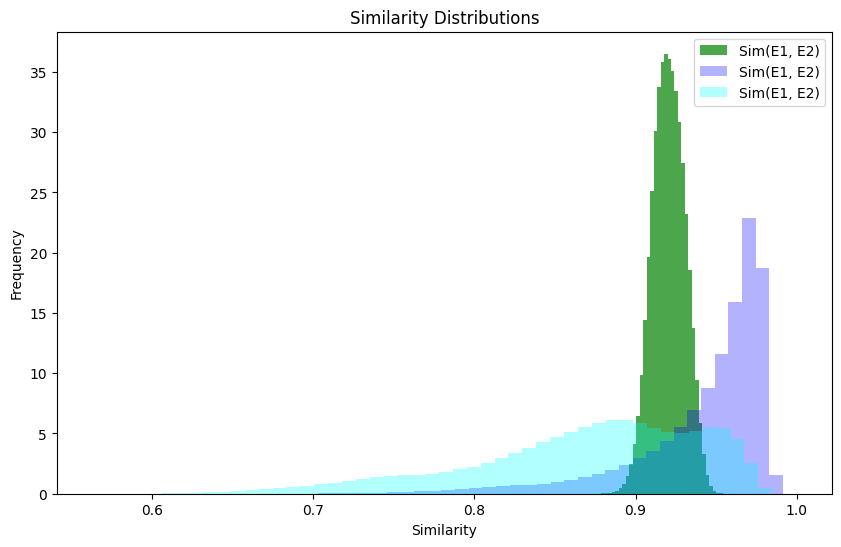

In [25]:
entity_matching(movie1, movie2, ours_movie, tokenizer, bert_base, tokenizer, tapas, tapas_tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/tapas/tokenization_tapas.py:2699: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/usr/local/lib/python3.10/dist-packages/transformers/models/tapas/tokenization_tapas.py:1493: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]


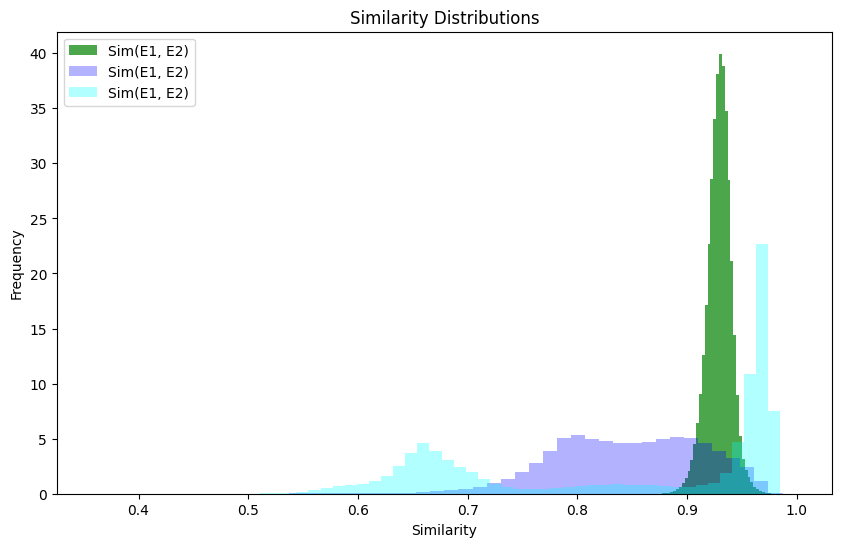

In [26]:
entity_matching(product1, product2, ours_product, tokenizer, bert_base, tokenizer, tapas, tapas_tokenizer)

### Corruption Experiment

In [17]:
def calculate_similarity(table1, table2, model, tokenizer):
    embeddings1 = np.array([get_table_embedding(row, model, tokenizer) for row in table1])
    embeddings2 = np.array([get_table_embedding(row, model, tokenizer) for row in table2])
    similarities = [cosine_similarity(e1.reshape(1, -1), e2.reshape(1, -1))[0][0] for e1, e2 in zip(embeddings1, embeddings2)]
    return np.mean(similarities)


def corruption_experiment(original_table1, original_table2, shared_columns, unshared_columns_for_table1, unshared_columns_for_table2, models):
    corruption_ratios = []
    similarity_scores = {model_name: [] for model_name in models.keys()}

    # Iterate over the corruption ratio from 0 to 1
    shared_length = len(shared_columns)
    unshared_length = len(unshared_columns_for_table1)
    for i in range(unshared_length + 1):
        # Calculate the corruption ratio
        corruption_ratio = (unshared_length - (i * 2)) / (shared_length + unshared_length - (i * 2))
        corruption_ratios.append(corruption_ratio)

        # Determine which columns to remove
        columns_to_keep_table1 = shared_columns + unshared_columns_for_table1[: len(unshared_columns_for_table1) - i]
        columns_to_keep_table2 = shared_columns + unshared_columns_for_table2[: len(unshared_columns_for_table2) - i]

        # Create corrupted tables
        corrupted_table1 = [{k: v for k, v in row.items() if k in columns_to_keep_table1} for row in original_table1]
        corrupted_table2 = [{k: v for k, v in row.items() if k in columns_to_keep_table2} for row in original_table2]

        # Calculate similarity for each model
        for model_name, (model, tokenizer) in models.items():
            similarity = calculate_similarity(corrupted_table1, corrupted_table2, model, tokenizer)
            similarity_scores[model_name].append(similarity)

    # Plot the similarity vs. corruption ratio for each model
    plt.figure(figsize=(10, 6))
    for model_name, scores in similarity_scores.items():
        plt.plot(corruption_ratios, scores, marker='o', label=model_name)

    plt.title('Similarity vs. Corruption Ratio')
    plt.xlabel('Corruption Ratio')
    plt.ylabel('Similarity')
    plt.legend()
    plt.show()

In [19]:
models = {
    'OURS': (ours_movie, tokenizer),
    'BERT_BASE': (bert_base, tokenizer),
    'TAPAS': (tapas, tapas_tokenizer)
}

corruption_experiment(movie1, movie2, shared_columns, unshared_columns_for_table1, unshared_columns_for_table2, models)


/usr/local/lib/python3.10/dist-packages/transformers/models/tapas/tokenization_tapas.py:2699: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = normalize_for_match(row[col_index].text)
/usr/local/lib/python3.10/dist-packages/transformers/models/tapas/tokenization_tapas.py:1493: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell = row[col_index]
/usr/local/lib/python3.10/dist-packages/transformers/models/tapas/tokenization_tapas.py:2699: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior).

OutOfMemoryError: CUDA out of memory. Tried to allocate 60.00 MiB. GPU 0 has a total capacity of 23.57 GiB of which 34.19 MiB is free. Process 3682593 has 3.18 GiB memory in use. Process 3870975 has 20.35 GiB memory in use. Of the allocated memory 20.04 GiB is allocated by PyTorch, and 69.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)